Processed data shape: (4998, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  4998 non-null   float64
 1   humidity     4998 non-null   float64
 2   weather      4998 non-null   object 
dtypes: float64(2), object(1)
memory usage: 117.3+ KB
None
   temperature  humidity weather
0    18.877778      0.47   Sunny
1    18.911111      0.46   Sunny
2    19.005556      0.46   Sunny
3    20.044444      0.40   Sunny
4    21.050000      0.40   Sunny

Class distribution:
weather
Sunny    2499
Cold     2499
Name: count, dtype: int64
Epoch 1/10


d:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5369 - loss: 0.7564 - val_accuracy: 0.9712 - val_loss: 0.5071
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9321 - loss: 0.4626 - val_accuracy: 0.9737 - val_loss: 0.2725
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9726 - loss: 0.2572 - val_accuracy: 0.9762 - val_loss: 0.1509
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9663 - loss: 0.1663 - val_accuracy: 0.9775 - val_loss: 0.1027
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9732 - loss: 0.1132 - val_accuracy: 0.9800 - val_loss: 0.0820
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9799 - loss: 0.0907 - val_accuracy: 0.9800 - val_loss: 0.0706
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9814 - loss: 0.0822 - val_accuracy: 0.9825 - val_loss: 0.0632
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9851 - loss: 0.0677 - val_accuracy: 0.9825 - val_

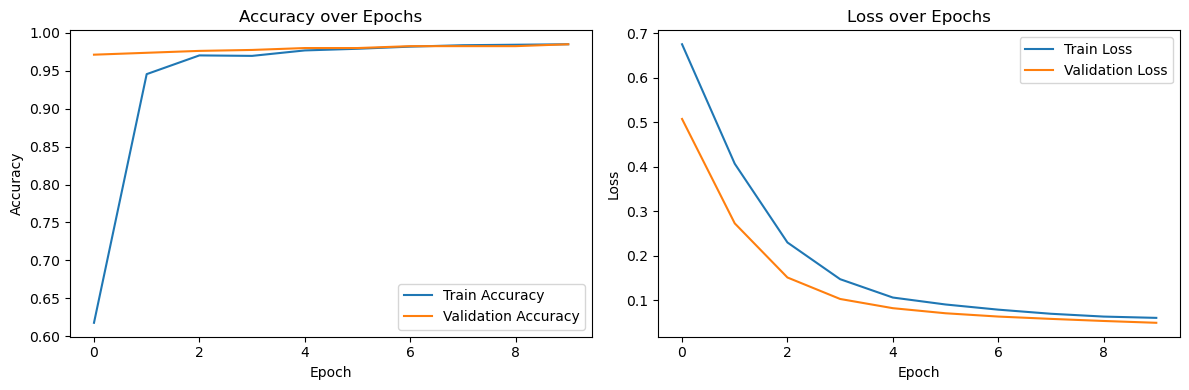


Test Accuracy: 0.9860
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Average inference time: 0.1416 ms per sample


In [2]:
# notebooks/3_model_training.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, 
                           precision_score, recall_score, f1_score, 
                           roc_auc_score, accuracy_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the preprocessed data
data_path = r"D:\College\Semster_8\IoT2\Task_2\tinyml-weather-classification\data\weather_data_labeled.csv"
df = pd.read_csv(data_path)

# Display basic info
print("Processed data shape:", df.shape)
print(df.info())
print(df.head())

# Check class distribution
print("\nClass distribution:")
print(df['weather'].value_counts())

# Prepare features and labels
X = df[['temperature', 'humidity']].values
y = df['weather'].map({'Sunny': 1, 'Cold': 0}).values  # Convert to binary (0: Cold, 1: Sunny)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a more compact model suitable for TinyML
model = Sequential([
    Dense(8, activation='relu', input_shape=(2,)),
    Dropout(0.1),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with a lower learning rate for better stability
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model and measure training time
start_train = time.time()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)
train_time = time.time() - start_train
print(f"\nTraining completed in {train_time:.2f} seconds")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Make predictions and measure inference speed
start_inference = time.time()
y_pred = (model.predict(X_test) > 0.5).astype(int)
inference_time = (time.time() - start_inference) / len(X_test) * 1000  # ms per sample
print(f"Average inference time: {inference_time:.4f} ms per sample")

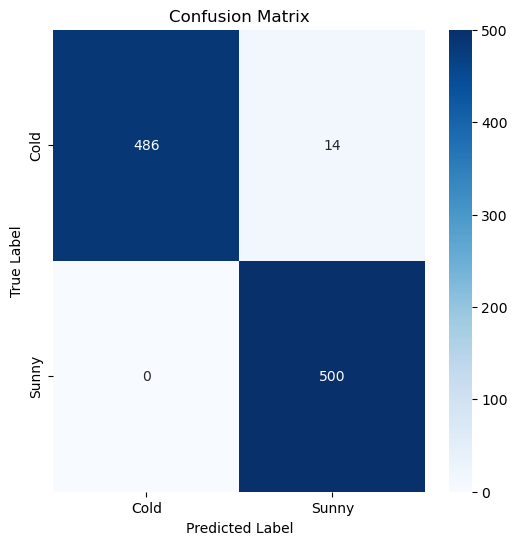

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step



Advanced Metrics:
Precision: 0.9728
Recall: 1.0000
F1 Score: 0.9862
ROC AUC: 0.9985

Classification Report:
              precision    recall  f1-score   support

        Cold       1.00      0.97      0.99       500
       Sunny       0.97      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


Real-time Capability Assessment:
- Model size: 65 parameters
- Training time: 4.07 seconds
- Inference speed: 0.1416 ms per sample
- Recommended max inference time for real-time: <10ms
✅ Model meets real-time requirements

Model saved to D:\College\Semster_8\IoT2\Task_2\tinyml-weather-classification\models\tensorflow\weather_model.h5
Scaler saved to D:\College\Semster_8\IoT2\Task_2\tinyml-weather-classification\models\tensorflow\scaler.pkl


In [3]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cold', 'Sunny'], 
            yticklabels=['Cold', 'Sunny'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict(X_test).ravel())

print("\nAdvanced Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Cold', 'Sunny']))

# Real-time capability assessment
print("\nReal-time Capability Assessment:")
print(f"- Model size: {model.count_params()} parameters")
print(f"- Training time: {train_time:.2f} seconds")
print(f"- Inference speed: {inference_time:.4f} ms per sample")
print("- Recommended max inference time for real-time: <10ms")

if inference_time < 10:
    print("✅ Model meets real-time requirements")
else:
    print("⚠️ Model may need optimization for real-time use")

# Save the trained model
model_path = r"D:\College\Semster_8\IoT2\Task_2\tinyml-weather-classification\models\tensorflow\weather_model.h5"
model.save(model_path)
print(f"\nModel saved to {model_path}")

# Save the scaler for later use
import joblib
scaler_path = r"D:\College\Semster_8\IoT2\Task_2\tinyml-weather-classification\models\tensorflow\scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")